In [1]:
import numpy as np
import pandas as pd

import os
import random

import warnings

warnings.filterwarnings(action='ignore')

path = '/opt/ml/input/data/'
dat = pd.read_csv(path + 'FE/FE_total.csv')
dat['last_answerCode'] = dat.groupby("userID")['answerCode'].shift(1).fillna(1)

In [2]:
_train = dat[dat['answerCode'] >= 0]
_test = dat[dat['answerCode'] < 0]

In [3]:
# valid 제작하는 함수 새로 개편.
# 예전 valid 제작 함수는 1분 걸렸는데 0.6초만에 끗~
_train['train_valid'] = 0
_train.loc[_train.drop_duplicates(subset='userID', keep = 'last').index, 'train_valid'] = -1
_valid = _train[_train['train_valid'] == -1]
_train = _train[_train['train_valid'] == 0]

In [4]:
# 모델에 적용하기 전 기본적인 데이터 전처리 부분
## 라벨링, 필요없는 칼럼 제거
_train_value = _train['answerCode']
_train.drop(['Timestamp', 'testId', 'train_valid', 'answerCode'], axis = 1, inplace = True) # ,'category_st_qcut_5'

_valid_value = _valid['answerCode']
_valid.drop(['Timestamp', 'testId', 'train_valid', 'answerCode'], axis = 1, inplace = True) # ,'category_st_qcut_5'

_test.drop(['Timestamp', 'testId', 'answerCode'], axis = 1, inplace = True) # ,'category_st_qcut_5'

In [58]:
# CatBoost에 적용하기 위해선 문자열 데이터로 변환 필요.
# 만약 범주형이 아니고 연속형(정수, 소수) 성질을 살리고 싶은 변수는 여기 drop에 적어두면 됨.(solve_time 같이.)
cat_columns = list(_train.drop(['solve_time'],axis=1).columns)

for col in cat_columns:
    _train[col] = _train[col].astype('str')
    _valid[col] = _valid[col].astype('str')
    _test[col] = _test[col].astype('str')

In [59]:
#!pip install catboost
# 가상환경에 패키지 설치 필요할듯
from catboost import CatBoostClassifier

# 하이퍼파라미터 수정할 여지가 많으니 추가나 수정하고 싶은 사람 수정해도 괜찮을듯.
# 일단 지난번에 사용했던 파라미터들 주석으로 들고 옴. 참고하면서 공부하면 좋을듯.

# params_cat = {
#     "task_type" : "GPU",
#     "devices" : '0',
#     "random_state": SEED,
#     'learning_rate': 0.04574578205475402, 
#     'bagging_temperature': 0.12172958098369972, 
#     'n_estimators': 2000, 
#     'max_depth': 8, 
#     'random_strength': 28, 
#     'l2_leaf_reg': 1.6285455533915874e-05, 
#     'min_child_samples': 18, 
#     'max_bin': 441, 
#     'od_type': 'Iter',
#     "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns),
# }

# model = CatBoostRegressor(**params_cat)

# 실제 적용한 모델은 learning_rate, iterations(=n_estimators, 아마도?)만 사용함.
cat_model = CatBoostClassifier(learning_rate=0.01, random_state = 1998, iterations=3000, task_type="GPU", eval_metric = 'AUC',max_depth = 8)
cat_model.fit(_train, _train_value, early_stopping_rounds=100, cat_features=cat_columns ,verbose=200, eval_set=(_valid, _valid_value))


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7880568	best: 0.7880568 (0)	total: 149ms	remaining: 7m 27s
200:	test: 0.8162647	best: 0.8162647 (200)	total: 30.6s	remaining: 7m 5s
400:	test: 0.8235539	best: 0.8235539 (400)	total: 56.1s	remaining: 6m 3s
600:	test: 0.8303389	best: 0.8303389 (600)	total: 1m 22s	remaining: 5m 27s
800:	test: 0.8337831	best: 0.8337831 (800)	total: 1m 48s	remaining: 4m 57s
1000:	test: 0.8353776	best: 0.8353776 (1000)	total: 2m 15s	remaining: 4m 29s
1200:	test: 0.8363374	best: 0.8363374 (1200)	total: 2m 41s	remaining: 4m 2s
1400:	test: 0.8371302	best: 0.8371302 (1400)	total: 3m 7s	remaining: 3m 34s
1600:	test: 0.8376858	best: 0.8376858 (1600)	total: 3m 34s	remaining: 3m 7s
1800:	test: 0.8382043	best: 0.8382061 (1795)	total: 3m 59s	remaining: 2m 39s
2000:	test: 0.8386095	best: 0.8386143 (1998)	total: 4m 25s	remaining: 2m 12s
2200:	test: 0.8389096	best: 0.8389121 (2195)	total: 4m 51s	remaining: 1m 45s
2400:	test: 0.8391651	best: 0.8391668 (2397)	total: 5m 16s	remaining: 1m 19s
2600:	test: 0.8393306

In [60]:
# valid score를 확인해봄.
# train 대비 valid score가 떨어짐. 과적합이 일어남. 마찬가지로 규제하는 하이퍼파라미터 필요.
from sklearn.metrics import accuracy_score, roc_auc_score

print('train score')
_train_pred = cat_model.predict_proba(_train)[:,1]
print(roc_auc_score(_train_value, _train_pred)) # auc
print(accuracy_score(_train_value, np.where(_train_pred >= 0.5, 1, 0))) # acc, 정확도

print('valid score')
_valid_pred = cat_model.predict_proba(_valid)[:,1]
print(roc_auc_score(_valid_value, _valid_pred)) # auc
print(accuracy_score(_valid_value, np.where(_valid_pred >= 0.5, 1, 0))) # acc, 정확도

train score
0.8732714465096981
0.8150806388211461
valid score
0.8395403647671291
0.7612201021230852


Text(0.5, 1.0, 'Feature Importance')

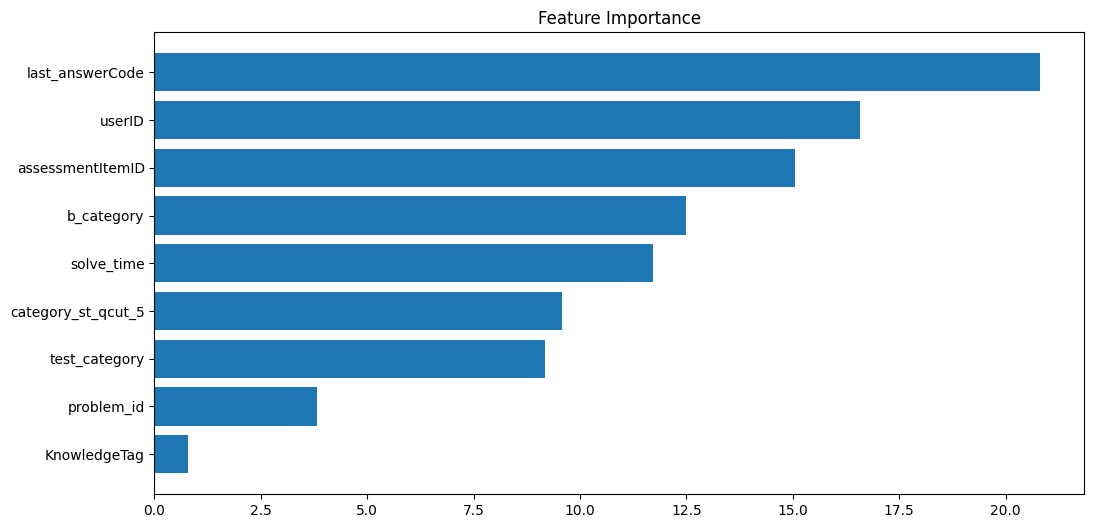

In [62]:
import matplotlib.pyplot as plt

feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(_valid.columns)[sorted_idx])
plt.title("Feature Importance")

In [63]:
# submission 제출하기 위한 코드

_test_pred = cat_model.predict_proba(_test)[:,1]
_test['prediction'] = _test_pred
submission = _test['prediction'].reset_index(drop = True).reset_index()
submission.rename(columns = {'index':'id'}, inplace = True)
submission.to_csv('../output/last_code_submission6.csv', index = False)

In [64]:
submission

,id,prediction
0,0,0.666816
1,1,0.765828
2,2,0.135723
3,3,0.799326
4,4,0.203975
...,...,...
739,739,0.018038
740,740,0.758823
741,741,0.908008
742,742,0.899756
